# Importing the dataset

In [1]:
#Dont forget to switch to T4 GPU on collab or local runtime for faster training

In [2]:
# Downloading the Dataset on collab/local notebook
!gdown http://drive.google.com/uc?id=1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ
!unzip -q dataset.zip   #Using the dataset by first unzipping it.

Downloading...
From (original): http://drive.google.com/uc?id=1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ
From (redirected): https://drive.google.com/uc?id=1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ&confirm=t&uuid=bb7965e3-0142-4cda-afee-221d158ef5b7
To: /content/dataset.zip
100% 1.13G/1.13G [00:25<00:00, 44.4MB/s]


# Import all the necessary python packages

In [9]:
import os  # Operating system interaction
import numpy as np  # Numerical computations
from tqdm import tqdm
import matplotlib.pyplot as plt  # Plotting
import torch  # Deep learning framework
import torchvision  # Computer vision utilities
import torch.nn as nn  # Neural network building blocks
import torch.optim as optim  # Optimization algorithms
from torch.autograd import Variable  # Automatic differentiation
from torchvision import models  # Pre-trained models
from tqdm.notebook import tqdm  # Progress bars
from sklearn.metrics import roc_auc_score, roc_curve, auc  # ROC curve metrics
from sklearn.preprocessing import label_binarize  # Label binarization
import torch.utils.data as data  # Data handling
from scipy import interp  # Interpolation functions
from itertools import cycle  # Looping utilities

# Set matplotlib backend for inline plotting
%matplotlib inline

# Preview the Data

Samples with no substructure: 


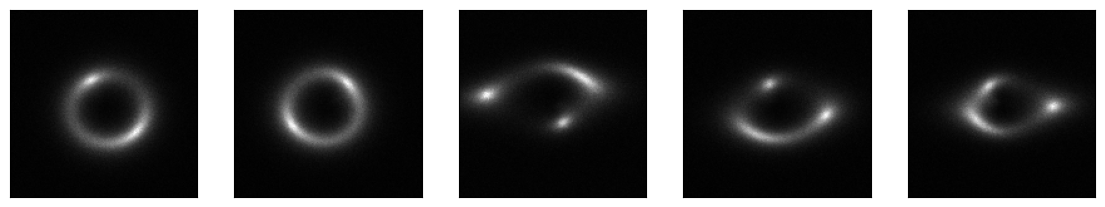

Samples with spherical substructure: 


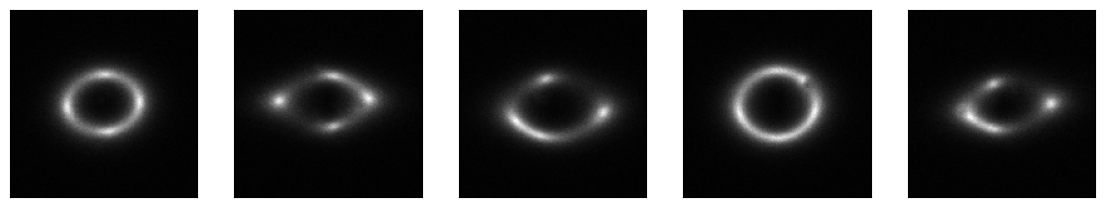

Samples with vortex substructure: 


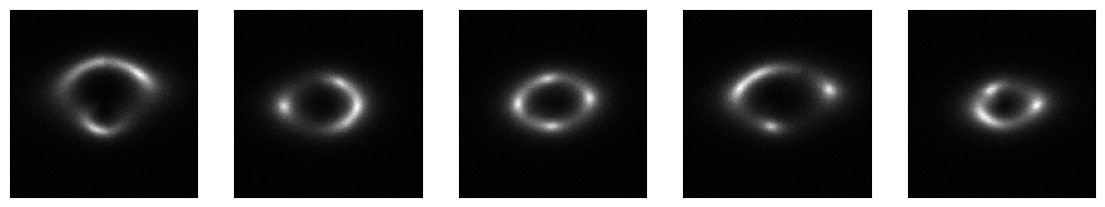

In [4]:
# Defining the input paths for different classes
train_path1 = './dataset/train/no'  # Path for samples with no substructure
train_files1 = [os.path.join(train_path1, f) for f in os.listdir(train_path1) if f.endswith(".npy")]

train_path2 = './dataset/train/sphere'  # Path for samples with spherical substructure
train_files2 = [os.path.join(train_path2, f) for f in os.listdir(train_path2) if f.endswith(".npy")]

train_path3 = './dataset/train/vort'  # Path for samples with vortex substructure
train_files3 = [os.path.join(train_path3, f) for f in os.listdir(train_path3) if f.endswith(".npy")]

# Number of samples to display per class
n = 5

# Plotting the samples with no substructure
print('Samples with no substructure: ')
plt.rcParams['figure.figsize'] = [14, 14]  # Set the size of the plot
for i, image in enumerate(train_files1[:n], 1):
    ax = plt.subplot(3, n, i)  # Creating subplot
    plt.imshow(np.load(image).reshape(150, 150), cmap='gray')  # Loading and displaying the image
    ax.get_xaxis().set_visible(False)  # Hide x-axis
    ax.get_yaxis().set_visible(False)  # Hide y-axis
plt.show()

# Plotting the samples with spherical substructure
print('Samples with spherical substructure: ')
plt.rcParams['figure.figsize'] = [14, 14]  # Set the size of the plot
for i, image in enumerate(train_files2[:n], 1):
    ax = plt.subplot(3, n, i)  # Creating subplot
    plt.imshow(np.load(image).reshape(150, 150), cmap='gray')  # Loading and displaying the image
    ax.get_xaxis().set_visible(False)  # Hide x-axis
    ax.get_yaxis().set_visible(False)  # Hide y-axis
plt.show()

# Plotting the samples with vortex substructure
print('Samples with vortex substructure: ')
plt.rcParams['figure.figsize'] = [14, 14]  # Setting the size of the plot
for i, image in enumerate(train_files3[:n], 1):
    ax = plt.subplot(3, n, i)  # Creating subplot
    plt.imshow(np.load(image).reshape(150, 150), cmap='gray')  # Loading and displaying the image
    ax.get_xaxis().set_visible(False)  # Hide x-axis
    ax.get_yaxis().set_visible(False)  # Hide y-axis
plt.show()

# Import Training and Validation Data

In [5]:
# Set Batch Size for data loaders
batch_size = 100

# Define a loader function for loading .npy files
def npy_loader(path):
    """
    Loads a .npy file from the given path.

    Args:
        path (str): Path to the .npy file.

    Returns:
        torch.Tensor: Tensor containing the loaded data.
    """
    sample = torch.from_numpy(np.load(path))
    return sample

# Define Data Loaders for training and validation datasets
train_data = torchvision.datasets.DatasetFolder(root='./dataset/train', loader=npy_loader, extensions='.npy')
print("Training Classes: " + str(train_data.class_to_idx))  # Display classes and their indices
train_data_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)

val_data = torchvision.datasets.DatasetFolder(root='./dataset/val', loader=npy_loader, extensions='.npy')
print("Validation Classes: " + str(val_data.class_to_idx))  # Display classes and their indices
val_data_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)

Training Classes: {'no': 0, 'sphere': 1, 'vort': 2}
Validation Classes: {'no': 0, 'sphere': 1, 'vort': 2}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Defining Models: CNN and Resnet18

# ResNet18 (Residual Network 18)

In [6]:
import torch.nn.functional as F

# Define the Residual Block
class ResidualBlock(nn.Module):
    """
    Residual block for ResNet architecture.

    Attributes:
        conv1 (nn.Conv2d): First convolutional layer.
        bn1 (nn.BatchNorm2d): Batch normalization layer after first convolution.
        relu (nn.ReLU): ReLU activation function.
        conv2 (nn.Conv2d): Second convolutional layer.
        bn2 (nn.BatchNorm2d): Batch normalization layer after second convolution.
        downsample (nn.Sequential): Downsample layer if needed.
    """

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

# Define the ResNet Model
class ResNet(nn.Module):
    """
    ResNet model architecture.

    Attributes:
        conv1 (nn.Conv2d): First convolutional layer.
        bn1 (nn.BatchNorm2d): Batch normalization layer after the first convolution.
        relu (nn.ReLU): ReLU activation function.
        maxpool (nn.MaxPool2d): Max pooling layer.
        layer1 (nn.Sequential): First layer of residual blocks.
        layer2 (nn.Sequential): Second layer of residual blocks.
        layer3 (nn.Sequential): Third layer of residual blocks.
        avgpool (nn.AdaptiveAvgPool2d): Adaptive average pooling layer.
        fc (nn.Linear): Fully connected layer for classification.
    """

    def __init__(self, block, layers, num_classes=3):
        super(ResNet, self).__init__()
        self.in_channels = 8
        self.conv1 = nn.Conv2d(1, 8, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(block, 8, layers[0])
        self.layer2 = self.make_layer(block, 16, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 120, layers[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(120, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Define ResNet18 model
def ResNet18():
    """
    Create ResNet18 model instance.

    Returns:
        ResNet: ResNet18 model.
    """
    return ResNet(ResidualBlock, [2, 2, 2])

# Create ResNet18 model instance
model = ResNet18()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ResNet18model = model.to(device)

In [7]:
# Check the model architecture
print(ResNet18model)

ResNet(
  (conv1): Conv2d(1, 8, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (

# Training and Testing the ResNet18 Model

**Training the ResNet18 Model on Training Data**

In [10]:
model = ResNet18model

# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Calculate the number of batches
n_batches_train = len(train_files1) * 3 // batch_size

# Train the model
n_epochs = 50  # Number of Training Epochs
loss_array = []
pbar = tqdm(range(1, n_epochs + 1), desc="Epochs")
for epoch in pbar:
    train_loss = 0.0
    train_acc = 0.0

    # Iterate over mini-batches
    for step, (x_tr, y_tr) in enumerate(train_data_loader):
        # Move data to device and convert to float
        data = x_tr.to(device).float()
        # Move labels to device
        labels = torch.tensor(y_tr, dtype=torch.long).to(device)

        optimizer.zero_grad()
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        correct = (preds == labels).float().sum()

        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += correct.item() / data.size(0)

    # Calculate average loss and accuracy for the epoch
    train_loss /= n_batches_train
    train_acc /= n_batches_train

    # Display the Training Stats for the epoch
    pbar.set_postfix({'Training Loss': train_loss, 'Training Acc': train_acc})# Save the model after the last epoch

torch.save(model.state_dict(), "resnet18_final.pth")

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-10-57f8c46ecccb>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(y_tr, dtype=torch.long).to(device)


**Testing the ResNet18 Model on Validation Data**

In [11]:
# Initialize lists to store predicted scores and true labels
y_score = []
y_test = []

# Iterate over mini-batches in the validation data loader
for _, (x_ts, y_ts) in enumerate(val_data_loader):
    # Move validation data to CUDA if available
    mini_val_data = x_ts.to(device).float() if torch.cuda.is_available() else x_ts.float()
    # Forward pass to get predicted scores
    scores = torch.nn.functional.softmax(model(mini_val_data), dim=1)
    # Convert scores to numpy array and detach from GPU
    y_score.append(scores.cpu().detach().numpy())
    # Convert true labels to numpy array and detach from GPU
    y_test.append(y_ts.cpu().detach().numpy())

# Concatenate predicted scores and true labels, and reshape them
y_score = np.asarray(y_score).reshape(-1, 3)
y_test = np.asarray(y_test).reshape(-1)

# Binarize true labels using label binarizer
y_val = label_binarize(y_test, classes=[0, 1, 2])

**Plotting the ROC Curve for ResNet18 Model**

<ipython-input-12-97b95af1fbff>:16: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


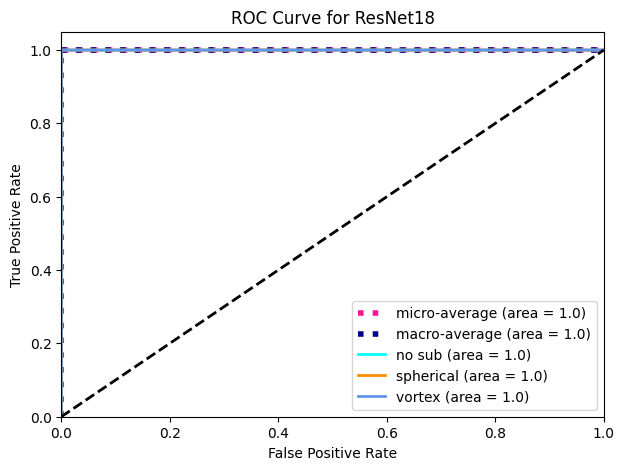

In [12]:
n_classes = y_val.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.rcParams['figure.figsize'] = [7, 5]
lw = 2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average (area = {})'
               ''.format(round(roc_auc["micro"],5)),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average (area = {})'
               ''.format(round(roc_auc["macro"],5)),
         color='navy', linestyle=':', linewidth=4)

labels = ['no sub', 'spherical', 'vortex']
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{} (area = {})'
             ''.format(labels[i], round(roc_auc[i],5)))

# Plot the ROC
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ResNet18')
plt.legend(loc="lower right", prop={"size":10})

# CNN (Convolution Neural Networks)

In [13]:
# Define the CNN Model
class CNN(nn.Module):
    """
    Convolutional Neural Network model for classification.

    Attributes:
        conv1 (nn.Conv2d): First convolutional layer.
        conv2 (nn.Conv2d): Second convolutional layer.
        conv3 (nn.Conv2d): Third convolutional layer.
        linear1 (nn.Linear): First fully connected layer.
        linear2 (nn.Linear): Second fully connected layer.
        tanh (nn.Tanh): Hyperbolic tangent activation function.
        avgpool (nn.AvgPool2d): Average pooling layer.
    """

    def __init__(self):
        super(CNN, self).__init__()

        # Define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=2, padding=0)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=2, padding=0)
        self.linear1 = nn.Linear(480, 84)
        self.linear2 = nn.Linear(84, 3)
        self.tanh = nn.Tanh()
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input data.

        Returns:
            torch.Tensor: Output predictions.
        """
        x = self.conv1(x)
        x = self.tanh(x)
        x = self.avgpool(x)
        x = self.conv2(x)
        x = self.tanh(x)
        x = self.avgpool(x)
        x = self.conv3(x)
        x = self.tanh(x)
        x = x.reshape(x.shape[0], -1)
        x = self.linear1(x)
        x = self.tanh(x)
        x = self.linear2(x)
        return x

# Determine device (GPU or CPU) for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the CNN model and move it to the appropriate device
CNNmodel = CNN().to(device)

In [14]:
# Check the model architecture
print(CNNmodel)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(2, 2))
  (linear1): Linear(in_features=480, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=3, bias=True)
  (tanh): Tanh()
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
)


# Training and Testing the CNN Model

**Training the CNN Model on Training Data**

In [15]:
model = CNNmodel

# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Calculate the number of batches
n_batches_train = len(train_files1) * 3 // batch_size

# Train the model
n_epochs = 50  # Number of Training Epochs
loss_array = []
pbar = tqdm(range(1, n_epochs + 1), desc="Epochs")
for epoch in pbar:
    train_loss = 0.0
    train_acc = 0.0

    # Iterate over mini-batches
    for step, (x_tr, y_tr) in enumerate(train_data_loader):
        # Move data to device and convert to float
        data = x_tr.to(device).float()
        # Move labels to device
        labels = torch.tensor(y_tr, dtype=torch.long).to(device)

        optimizer.zero_grad()
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        correct = (preds == labels).float().sum()

        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += correct.item() / data.size(0)

    # Calculate average loss and accuracy for the epoch
    train_loss /= n_batches_train
    train_acc /= n_batches_train

    # Display the Training Stats for the epoch
    pbar.set_postfix({'Training Loss': train_loss, 'Training Acc': train_acc})

torch.save(model.state_dict(), "cnn_final.pth")

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-15-04d0377f081c>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(y_tr, dtype=torch.long).to(device)


**Testing the CNN Model on Validation Data**

In [16]:
# Initialize lists to store predicted scores and true labels
y_score = []
y_test = []

# Iterate over mini-batches in the validation data loader
for _, (x_ts, y_ts) in enumerate(val_data_loader):
    # Move validation data to CUDA if available
    mini_val_data = x_ts.to(device).float() if torch.cuda.is_available() else x_ts.float()
    # Forward pass to get predicted scores
    scores = torch.nn.functional.softmax(model(mini_val_data), dim=1)
    # Convert scores to numpy array and detach from GPU
    y_score.append(scores.cpu().detach().numpy())
    # Convert true labels to numpy array and detach from GPU
    y_test.append(y_ts.cpu().detach().numpy())

# Concatenate predicted scores and true labels, and reshape them
y_score = np.asarray(y_score).reshape(-1, 3)
y_test = np.asarray(y_test).reshape(-1)

# Binarize true labels using label binarizer
y_val = label_binarize(y_test, classes=[0, 1, 2])

**Plotting the ROC Curve for CNN Model**

<ipython-input-17-41598b1a359a>:16: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


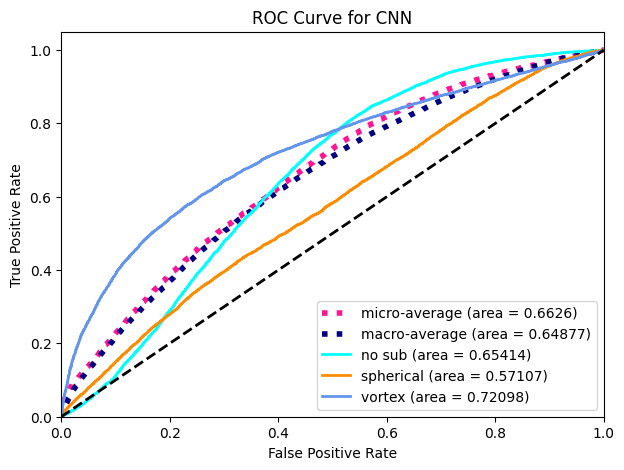

In [17]:
n_classes = y_val.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.rcParams['figure.figsize'] = [7, 5]
lw = 2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average (area = {})'
               ''.format(round(roc_auc["micro"],5)),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average (area = {})'
               ''.format(round(roc_auc["macro"],5)),
         color='navy', linestyle=':', linewidth=4)

labels = ['no sub', 'spherical', 'vortex']
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{} (area = {})'
             ''.format(labels[i], round(roc_auc[i],5)))

# Plot the ROC
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN')
plt.legend(loc="lower right", prop={"size":10})